In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import pandas as pd
from utilities.Path_Join import p_join
from dateutil.relativedelta import relativedelta
from utilities.Preprocessing_for_cropped import preproc_and_crop

In [28]:
class FCM:
    def __init__(self, image, image_bit, n_clusters, m, epsilon, max_iter):
        '''Modified Fuzzy C-means clustering
        <image>: 2D array, grey scale image.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <max_iter>: int, max number of iterations.
        '''

        # -------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be a positive integer.")
        if m < 1:
            raise Exception("<m> needs to be > 1.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.image_bit = image_bit
        self.n_clusters = n_clusters  # number of clusters/segments to create
        self.m = m  # fuzziness parameter
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.shape = image.shape  # image shape
        self.X = image.flatten().astype('float')  # shape: (number of pixels)
        self.numPixels = image.size

    # ---------------------------------------------
    def initial_u(self):
        # each jth cluster (column) contains the cluster membership of the ith data point (ith row)
        # the sum of the memberships for each data point is equal to one.

        u = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx % self.n_clusters == ii
            u[idxii, ii] = 1
        return u

    def update_u(self):
        '''Compute weights (cluster memberships)'''
        c_mesh, idx_mesh = np.meshgrid(self.c, self.X)  # self.c centroids of the clusters
        power = 2. / (self.m - 1)  # self.c defined in form_clusters()
        a = abs(idx_mesh - c_mesh) ** power
        b = np.sum((1. / abs(idx_mesh - c_mesh)) ** power, axis=1)

        return 1. / (a * b[:, None])

    def update_c(self):
        '''Compute centroid of clusters'''  # vectorization in python to speed up the computing time
        numerator = np.dot(self.X, self.u ** self.m)
        denominator = np.sum(self.u ** self.m, axis=0)
        return numerator / denominator  # returns a matrix of shape (1,num_centroids)

    def form_clusters(self):
        '''Iterative training'''
        d = 100
        self.u = self.initial_u()  # initializing the weights
        if self.max_iter != -1:
            i = 0
            self.iterate( i, True)
        else:
            i = 0
            self.iterate( i, d > self.epsilon)
        self.segmentimage()

    def iterate(self, i, condition):
        cnt = 0
        start_dt1 = datetime.datetime.now()
        while condition:
            start_dt = datetime.datetime.now()
            cnt += 1
            self.c = self.update_c()  # compute the centroids of the clusters
            old_u = np.copy(self.u)
            self.u = self.update_u()
            d = np.sum(abs(self.u - old_u))
            end_dt = datetime.datetime.now()
            diff = relativedelta(end_dt, start_dt)
            print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
            print("Iteration %d : cost = %f" % (i, d))

            if d < self.epsilon or i > self.max_iter:
                print('Converge at iteration {}'.format(cnt))
                end_dt1 = datetime.datetime.now()
                diff = relativedelta(end_dt1, start_dt1)
                print("duration time: %s:%s:%s:%s" % (diff.hours, diff.minutes, diff.seconds, diff.microseconds))
                break
            i += 1

    def defuzzify(self):
        return np.argmax(self.u, axis=1)  # Returns the indices of the maximum values along an axis.
        # returns the max membership value of each data point

    def segmentimage(self):
        '''Segment image based on max weights'''

        result = self.defuzzify()
        self.result = result.reshape(self.shape).astype('int')

        return self.result

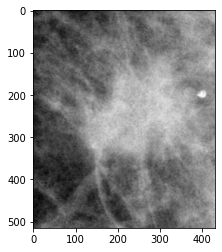

In [29]:
df = pd.read_excel(r"C:\Users\Asus\Desktop\PCD\Organized dataset\metadata\metadata_good2.0.xlsx")
parent_dir =r'C:\Users\Asus\Desktop\PCD\Organized dataset\curated'
image = mpimg.imread(p_join(parent_dir,df['image full mammo path'][0]))
center = eval(df['center of roi'][0])
shape = eval(df['Shape of cropped image'][0])
crop = preproc_and_crop(image, center, shape)
plt.imshow(crop,cmap='gray')

In [30]:
            #--------------Clustering------------
cluster = FCM(crop, image_bit=8, n_clusters=3, m=1.5, epsilon=0.0001, max_iter=1000)
cluster.form_clusters()
result=cluster.result

    #if IS_SAVE:

        #plt.savefig(seg_result_path, dpi=300)
        #plt.close()


iter: 1, time interval: 0:0:0:122408
Iteration 0 : cost = 295951.530519
iter: 2, time interval: 0:0:0:147104
Iteration 1 : cost = 1858.970740
iter: 3, time interval: 0:0:0:169244
Iteration 2 : cost = 8520.682990
iter: 4, time interval: 0:0:0:169259
Iteration 3 : cost = 36237.385106
iter: 5, time interval: 0:0:0:162770
Iteration 4 : cost = 109010.174335
iter: 6, time interval: 0:0:0:153649
Iteration 5 : cost = 160854.040242
iter: 7, time interval: 0:0:0:162727
Iteration 6 : cost = 91533.962566
iter: 8, time interval: 0:0:0:169244
Iteration 7 : cost = 33482.518458
iter: 9, time interval: 0:0:0:153674
Iteration 8 : cost = 11283.392196
iter: 10, time interval: 0:0:0:162725
Iteration 9 : cost = 3780.830283
iter: 11, time interval: 0:0:0:169302
Iteration 10 : cost = 1469.599795
iter: 12, time interval: 0:0:0:162787
Iteration 11 : cost = 1079.816722
iter: 13, time interval: 0:0:0:153648
Iteration 12 : cost = 853.549421
iter: 14, time interval: 0:0:0:184868
Iteration 13 : cost = 681.700234
ite

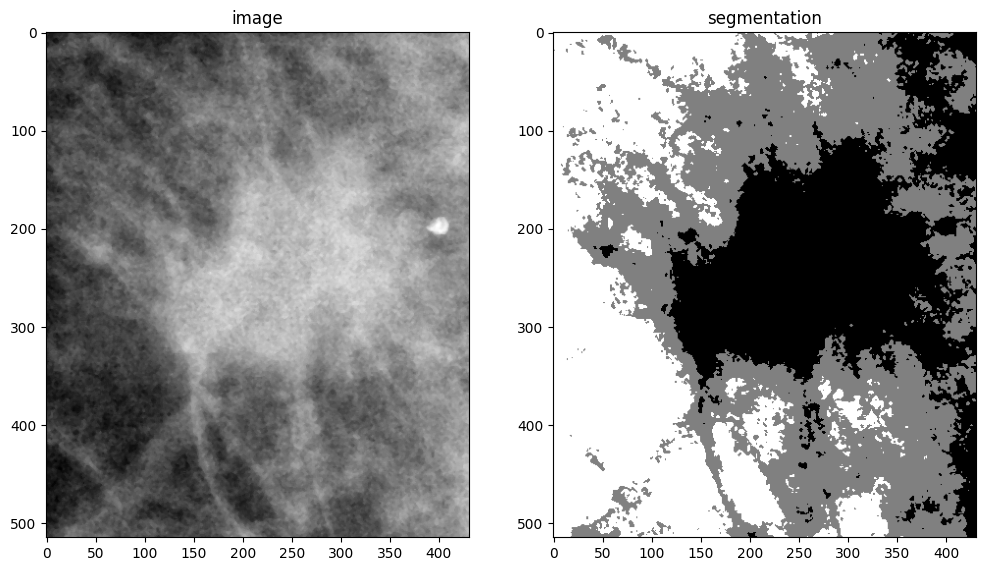

In [24]:
fig=plt.figure(figsize=(12,8),dpi=100)

ax1=fig.add_subplot(1,2,1)
ax1.imshow(crop,cmap='gray')
ax1.set_title('image')

ax2=fig.add_subplot(1,2,2)
ax2.imshow(result,cmap='gray')
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

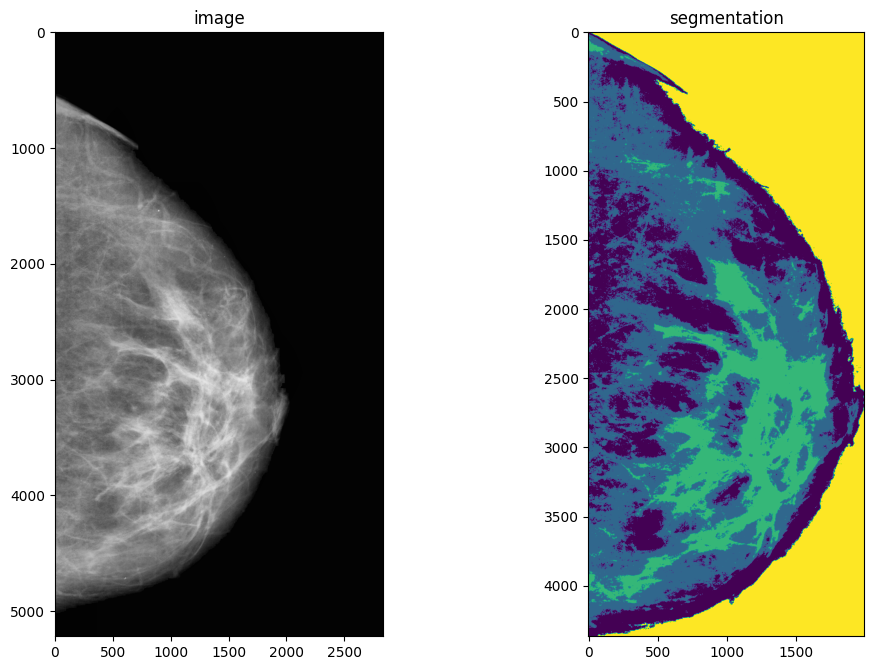

In [9]:
fig=plt.figure(figsize=(12,8),dpi=100)

ax1=fig.add_subplot(1,2,1)
ax1.imshow(image,cmap='gray')
ax1.set_title('image')

ax2=fig.add_subplot(1,2,2)
ax2.imshow(result)
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

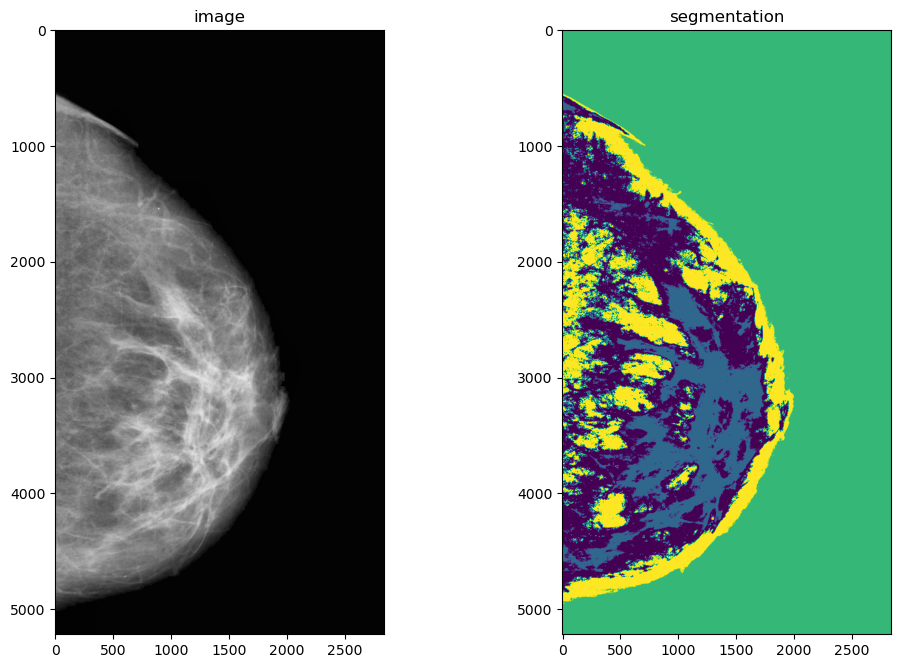

In [8]:
fig=plt.figure(figsize=(12,8),dpi=100)

ax1=fig.add_subplot(1,2,1)
ax1.imshow(image,cmap='gray')
ax1.set_title('image')

ax2=fig.add_subplot(1,2,2)
ax2.imshow(result)
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

In [9]:
plt.imsave(r'C:\Users\Asus\Desktop\PCD\result_FCM_clusters.jpg',result)

In [7]:
for a in [result]:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (4567, 2873)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: int32
min value, max value: (0, 3)
---
